In [183]:
import pandas as pd
import xgboost as xgb
import numpy as np

from feat_eng import *

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

import matplotlib.pyplot as plt

### Single Step Model

In [184]:
data = get_pollutant_data('PM2.5', lag = 24, window_size = 72, exog = True)

train_end = '2016-08-31 23:59:00'
val_end = '2017-01-31 23:59:00'
data_train, data_val, data_test = split_data(data, train_end, val_end)

X_train, y_train = data_train.iloc[:, :-1], data_train.iloc[:, -1]
X_val, y_val = data_val.iloc[:, :-1], data_val.iloc[:, -1]
X_test, y_test = data_test.iloc[:, :-1], data_test.iloc[:, -1]

Dates train      : 2013-03-03 23:00:00 --- 2016-08-31 23:00:00  (n=30649)
Dates validation : 2016-09-01 00:00:00 --- 2017-01-31 23:00:00  (n=3672)
Dates test       : 2017-02-01 00:00:00 --- 2017-02-28 22:00:00  (n=671)


In [185]:
model = xgb.XGBRegressor(
    n_estimators = 100,
    learning_rate = 0.1,
    max_depth = 5,
    random_state = 11,
    enable_categorical = True,
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [186]:
param_grid = {
    'n_estimators': [100, 250, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.25],
    'subsample': [0.5, 0.75, 1]
}

tscv = TimeSeriesSplit(
    n_splits = 4,
)

search = RandomizedSearchCV(
    estimator = model,
    param_distributions = param_grid,
    n_iter = 30,
    scoring = 'neg_mean_absolute_error',
    cv = tscv,
    verbose = 1,
    n_jobs = 1
)

search.fit(X_val, y_val)

Fitting 4 folds for each of 30 candidates, totalling 120 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=True,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma...
                                          max_delta_step=None, max_depth=5,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=100,
                                          n_jobs=None, num_parallel_tree=None, ...),
                   n_iter=30, n_jobs=1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.25],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 250, 500],
                                        'subsample': [0.5, 0.75, 1]},
                   scoring='neg_mean_absolute_error', verbose=1)

In [187]:
search_results = pd.DataFrame(data = search.cv_results_)
search_results.sort_values(by = 'rank_test_score', axis = 0, ascending = True).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
14,0.636494,0.043066,0.006573,0.000214,0.50,500,3,0.01,"{'subsample': 0.5, 'n_estimators': 500, 'max_d...",-8.911135,-8.661835,-20.929382,-11.608448,-12.527700,4.986425,1
15,0.661043,0.030496,0.006247,0.000214,0.75,500,3,0.01,"{'subsample': 0.75, 'n_estimators': 500, 'max_...",-8.906797,-8.964657,-20.821232,-11.452740,-12.536357,4.892446,2
9,0.301501,0.023128,0.005606,0.000150,0.75,250,3,0.10,"{'subsample': 0.75, 'n_estimators': 250, 'max_...",-9.212456,-9.307109,-20.833970,-11.857820,-12.802839,4.756656,3
29,1.413877,0.215916,0.007373,0.000527,0.50,500,5,0.01,"{'subsample': 0.5, 'n_estimators': 500, 'max_d...",-10.125153,-8.293439,-21.812071,-11.800807,-13.007868,5.232277,4
21,1.253436,0.065545,0.006804,0.000296,0.75,500,5,0.01,"{'subsample': 0.75, 'n_estimators': 500, 'max_...",-9.992735,-8.619562,-21.792596,-11.683394,-13.022072,5.178637,5


In [188]:
best_params = search_results[search_results['rank_test_score'] == 1]['params']
best_params

14    {'subsample': 0.5, 'n_estimators': 500, 'max_d...
Name: params, dtype: object

In [189]:
best_model = search.best_estimator_
best_model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [190]:
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f'Mean Absolute Error:       {mae:.3f} \n'
      f'Root Mean Squared Error:   {rmse:.3f}')

Mean Absolute Error:       6.169 
Root Mean Squared Error:   11.199


In [191]:
single_error = {'MAE': [mae], 'RMSE': [rmse]}

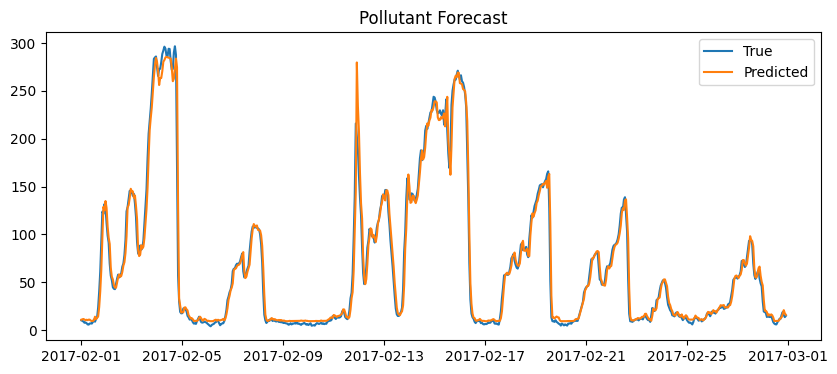

In [192]:
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test.values[:], label='True')
plt.plot(y_test.index, y_pred[:], label='Predicted')
plt.legend()
plt.title('Pollutant Forecast')
plt.show()

### Recursive Multi-step Model

In [193]:
lags = 24
window = 24

multi_data = get_pollutant_data('PM2.5', lags, window, False)

train_end = '2016-08-31 23:59:00'
val_end = '2017-01-31 23:59:00'
multi_data_train, multi_data_val, multi_data_test = split_data(multi_data, train_end, val_end)

X_train_multi, y_train_multi = multi_data_train.iloc[:, :-1], multi_data_train.iloc[:, -1]
X_val_multi, y_val_multi = multi_data_val.iloc[:, :-1], multi_data_val.iloc[:, -1]
X_test_multi, y_test_multi = multi_data_test.iloc[:, :-1], multi_data_test.iloc[:, -1]

Dates train      : 2013-03-02 00:00:00 --- 2016-08-31 23:00:00  (n=30696)
Dates validation : 2016-09-01 00:00:00 --- 2017-01-31 23:00:00  (n=3672)
Dates test       : 2017-02-01 00:00:00 --- 2017-02-27 23:00:00  (n=648)


In [194]:
#train a new model with the best parameters found tuning the single step model
best_model.fit(X_train_multi, y_train_multi)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [195]:
param_grid = {
    'n_estimators': [100, 250, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.25],
    'subsample': [0.5, 0.75, 1]
}

tscv = TimeSeriesSplit(
    n_splits = 4,
)

search_multi = RandomizedSearchCV(
    estimator = best_model,
    param_distributions = param_grid,
    n_iter = 30,
    scoring = 'neg_mean_absolute_error',
    cv = tscv,
    verbose = 1,
    n_jobs = 1
)

search_multi.fit(X_val_multi, y_val_multi)

Fitting 4 folds for each of 30 candidates, totalling 120 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=True,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma...
                                          max_delta_step=None, max_depth=3,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=500,
                                          n_jobs=None, num_parallel_tree=None, ...),
                   n_iter=30, n_jobs=1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.25],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 250, 500],
                                        'subsample': [0.5, 0.75, 1]},
                   scoring='neg_mean_absolute_error', verbose=1)

In [196]:
best_model_multi = search_multi.best_estimator_

In [197]:
def recursive_forecast(origin, forecast_window):

    forecasts = []
    input_array = np.array(X_test_multi.iloc[origin, :]).reshape(1, -1)
    
    for step in range(forecast_window):
        pred = best_model_multi.predict(input_array)[0]
        forecasts.append(pred)

        for i in range(len(input_array[0]) - 1, 0, -1):
            input_array[0, i] = input_array[0, i - 1]   
        input_array[0, 0] = pred
        input_array[0, -1] = np.mean(input_array[0, :-1])

    y_true = y_test_multi.iloc[origin : origin + forecast_window].values
    mae = mean_absolute_error(y_true, forecasts)
    rmse = root_mean_squared_error(y_true, forecasts)

    return mae, rmse

In [198]:
errors = []

for forecast_window in range(1, 25):
    mae_list = []
    rmse_list = []
    for origin in range(len(y_test_multi) - forecast_window):
        mae_list.append(recursive_forecast(origin, forecast_window)[0])
        rmse_list.append(recursive_forecast(origin, forecast_window)[1])

    agg_mae = np.mean(mae_list)
    agg_rmse = np.mean(rmse_list)

    errors.append({'MAE':agg_mae, 'RMSE':agg_rmse, 'Forecast Horizon': forecast_window})

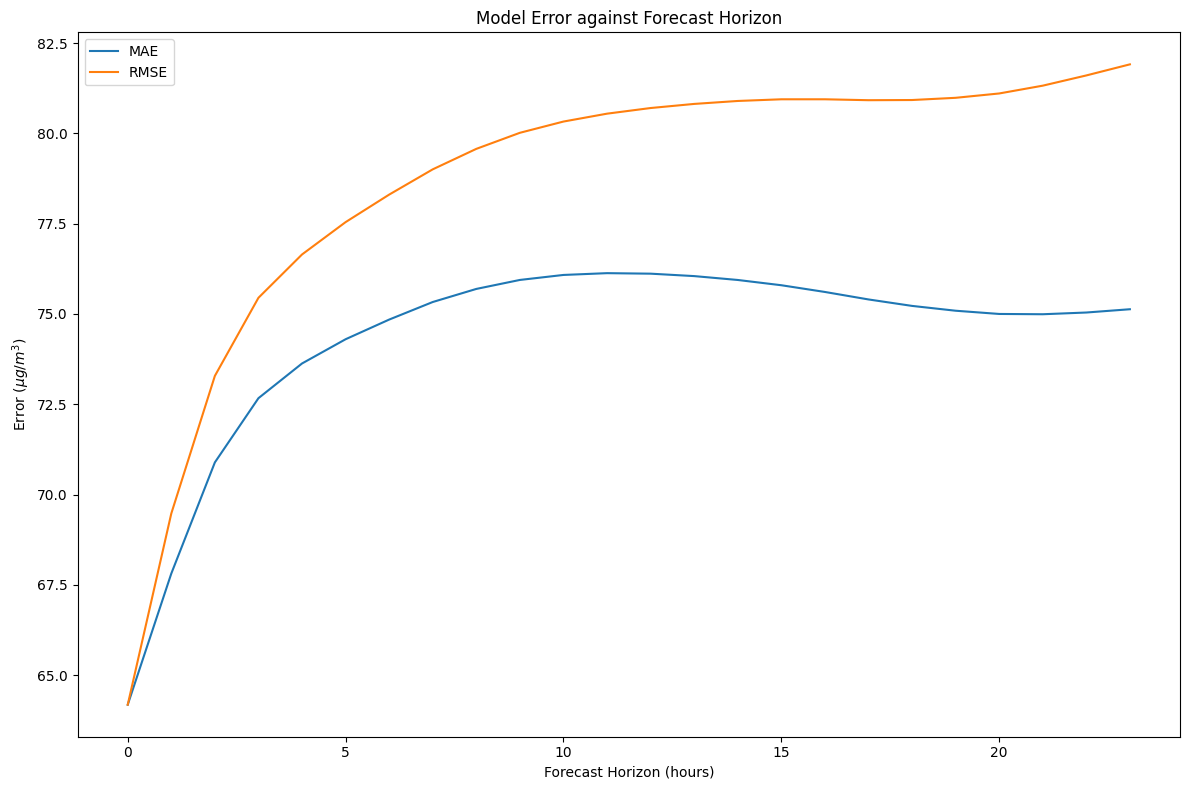

In [199]:
multi_error_df = pd.DataFrame(errors)

fig = plt.figure(figsize = (12, 8))
plt.plot(multi_error_df['MAE'], label = 'MAE')
plt.plot(multi_error_df['RMSE'], label = 'RMSE')

plt.title('Model Error against Forecast Horizon')
plt.legend()
plt.xlabel('Forecast Horizon (hours)')
plt.ylabel(r'Error ($\mu g/m^3$)')
plt.tight_layout()

### SKForecast Model

In [200]:
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold, bayesian_search_forecaster, backtesting_forecaster
from skforecast.preprocessing import RollingFeatures

In [201]:
skf_data = get_pollutant_data('PM2.5', lag = 1, window_size = 1, exog = False)

train_end = '2016-12-31 23:59:00'
val_end = '2017-01-31 23:59:00'
skf_data_train, skf_data_val, skf_data_test = split_data(skf_data, train_end, val_end)

X_train_skf, y_train_skf = skf_data_train.iloc[:, 0], skf_data_train.iloc[:, -1]
X_val_skf, y_val_skf = skf_data_val.iloc[:, 0], skf_data_val.iloc[:, -1]
X_test_skf, y_test_skf = skf_data_test.iloc[:, 0], skf_data_test.iloc[:, -1]

Dates train      : 2013-03-01 01:00:00 --- 2016-12-31 23:00:00  (n=33647)
Dates validation : 2017-01-01 00:00:00 --- 2017-01-31 23:00:00  (n=744)
Dates test       : 2017-02-01 00:00:00 --- 2017-02-28 22:00:00  (n=671)


In [202]:
window_features = RollingFeatures(stats = 'mean', window_sizes = 72)
forecaster = ForecasterRecursive(
    regressor = xgb.XGBRegressor(
        n_estimators = 500,
        max_depth = 7, 
        learning_rate = 0.01,
        subsample = 1,
        random_state = 11
    ),
    lags = 24,
    window_features = window_features
)


forecaster.fit(y = y_train_skf.asfreq('1h'))
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: XGBRegressor 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Window features: ['roll_mean_72'] 
Window size: 72 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2013-03-01 01:00:00'), Timestamp('2016-12-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: 
    {'objective': 'reg:squarederror', 'base_score': None, 'booster': None,
    'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None,
    'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None,
    'enable_categorical': False, 'eval_metric': None, 'feature_types': None,
    'feature_weights': None, 'gamma': None, 'grow_policy': None,
    'importance_type': None, 'interaction_constraints': None, 'learning_rate':
    0.01, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None,
    'max_delta_step': None, 'max_depth': 7, 'max_leaves': None,
    'min_child_weight': None, 'missing': nan, 'monotone_constraints': None,
    'multi_strategy': None, 'n_estimators': 500, 'n_jobs': None,
    'num_parallel_tree': None, 'random_state': 11, 'reg_alpha': None,
    'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None,
    'subsample': 1, 'tree_method': None, 'validate_parameters': None,
    'verbosity': None} 
fit_kwargs: {} 
Creation date: 2025-05-15 18:48:43 
Last fit date: 2025-05-15 18:48:45 
Skforecast version: 0.15.1 
Python version: 3.13.2 
Forecaster id: None

In [203]:
# Create forecaster
forecaster = ForecasterRecursive(
                regressor       = xgb.XGBRegressor(random_state=11, enable_categorical=True),
                lags            = 24,
                window_features = window_features
            )

# Create cv folds for time series data
tsfcv = TimeSeriesFold(
            steps = 24,
            initial_train_size = len(y_train_skf),
            fixed_train_size = False,
            refit = 4
        )


# Lags grid
lags_grid = [48, 72, [1, 2, 3, 23, 24, 25, 167, 168, 169], [1, 2, 3, 23, 24, 25, 47, 48, 49, 71, 72, 73]]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'subsample'       : trial.suggest_float('subsample', 0.1, 1),
        'gamma'           : trial.suggest_float('gamma', 0, 1),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    } 
    return search_space

results_search, _ = bayesian_search_forecaster(
                                    forecaster   = forecaster,
                                    y            = pd.concat([y_train_skf, y_val_skf]).asfreq('1h'),
                                    search_space = search_space,
                                    cv           = tsfcv,
                                    metric       = 'mean_absolute_error',
                                    n_trials     = 20
                    )

  0%|          | 0/20 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3  23  24  25 167 168 169] 
  Parameters: {'n_estimators': 900, 'max_depth': 8, 'learning_rate': 0.02216107964289138, 'subsample': 0.322737400294683, 'gamma': 0.5901618762275005, 'reg_alpha': 0.23963541990675707, 'reg_lambda': 0.43004318730299107}
  Backtesting metric: 50.26312669536973


In [204]:
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: XGBRegressor 
Lags: [  1   2   3  23  24  25 167 168 169] 
Window features: ['roll_mean_72'] 
Window size: 169 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2013-03-01 01:00:00'), Timestamp('2017-01-31 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: h 
Regressor parameters: 
    {'objective': 'reg:squarederror', 'base_score': None, 'booster': None,
    'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None,
    'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None,
    'enable_categorical': True, 'eval_metric': None, 'feature_types': None,
    'feature_weights': None, 'gamma': 0.5901618762275005, 'grow_policy': None,
    'importance_type': None, 'interaction_constraints': None, 'learning_rate':
    0.02216107964289138, 'max_bin': None, 'max_cat_threshold': None,
    'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 8,
    'max_leaves': None, 'min_child_weight': None, 'missing': nan,
    'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 900,
    'n_jobs': None, 'num_parallel_tree': None, 'random_state': 11, 'reg_alpha':
    0.23963541990675707, 'reg_lambda': 0.43004318730299107, 'sampling_method':
    None, 'scale_pos_weight': None, 'subsample': 0.322737400294683,
    'tree_method': None, 'validate_parameters': None, 'verbosity': None} 
fit_kwargs: {} 
Creation date: 2025-05-15 18:48:46 
Last fit date: 2025-05-15 18:59:27 
Skforecast version: 0.15.1 
Python version: 3.13.2 
Forecaster id: None

In [205]:
score, predictions = backtesting_forecaster(
                        forecaster = forecaster,
                        y = pd.concat([y_train_skf, y_val_skf, y_test_skf]).asfreq('1h'),
                        cv = tsfcv,
                        metric = ['mean_absolute_error', 'mean_squared_error']
)

  0%|          | 0/59 [00:00<?, ?it/s]

In [206]:
score['root_mean_squared_error'] = score['mean_squared_error'] ** 0.5
score 

,mean_absolute_error,mean_squared_error,root_mean_squared_error
0,47.319214,6406.526517,80.04078


In [207]:
skf_errors = {'MAE':score['mean_absolute_error'], 'RMSE':score['root_mean_squared_error']}

### Results

In [208]:
table1 = multi_error_df[multi_error_df['Forecast Horizon'].isin([12, 24])].drop('Forecast Horizon', axis = 1)
table2 = pd.DataFrame(single_error)
table3 = pd.DataFrame(skf_errors)

In [211]:
errors_table = pd.concat([table1, table2, table3])
errors_table['Model'] = ['Recursive Multistep 12h', 'Recursive Multistep 24h', 'Single Step 1h', 'skforecast Multistep 24h']
errors_table.sort_values('MAE', inplace = True)
errors_table.reset_index(drop = True, inplace = True)

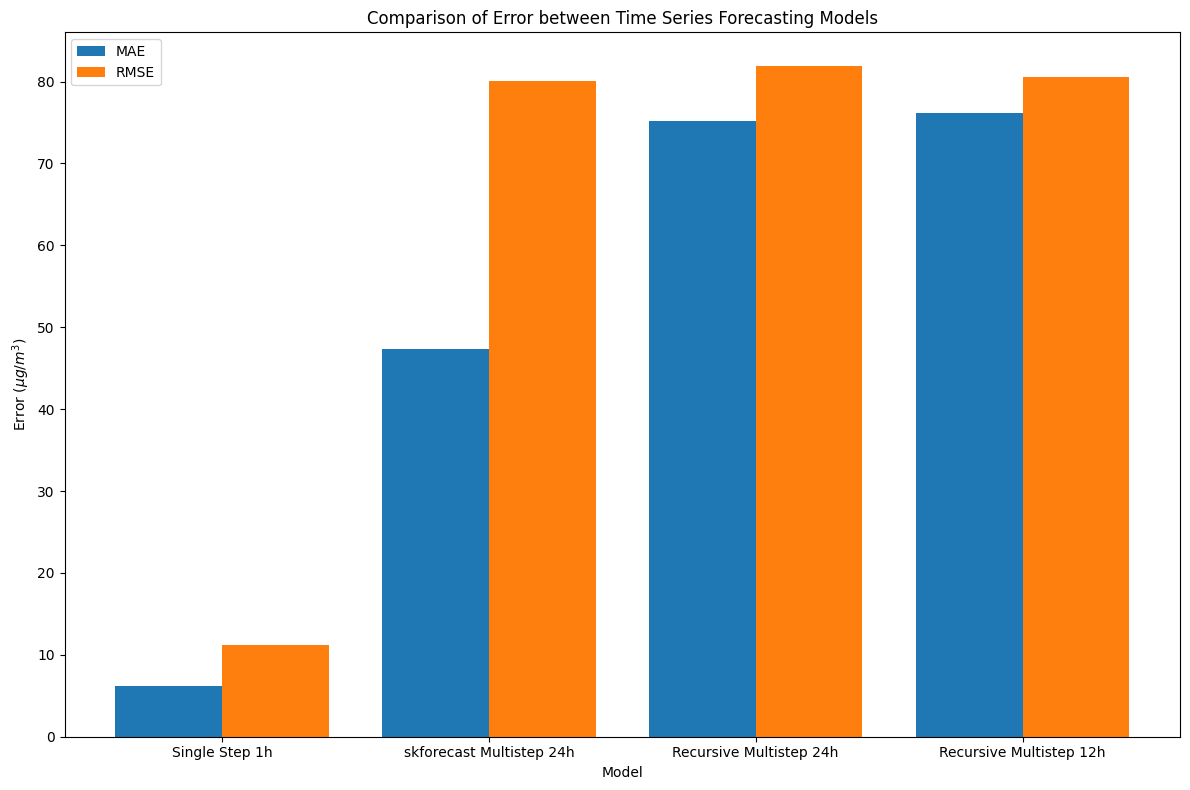

In [212]:
fig = plt.figure(figsize = (12, 8))

w = 0.4
plt.bar(x = errors_table.index - w/2 ,height = errors_table['MAE'], width = w, label = 'MAE')
plt.bar(x = errors_table.index + w/2 ,height = errors_table['RMSE'], width = w, label = 'RMSE')

plt.title('Comparison of Error between Time Series Forecasting Models')
plt.xticks(ticks = [0, 1, 2, 3], labels = errors_table['Model'])
plt.xlabel('Model')
plt.ylabel(r'Error ($\mu g/m^3$)')
plt.legend()
plt.tight_layout()